# Crime Data Analysis

In [ ]:
#!pip install imblearn
#!pip install folium
#!pip install -U imbalanced-learn       #restart after installing
#!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
#from xgboost import XGBClassifier
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import xgboost
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import MarkerCluster
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

# Importing and cleaning data

In [3]:
df=pd.read_csv('LA_2017-18.csv')

In [4]:
df.head()

DR Number Date Reported Date Occurred  Time Occurred  Area ID Area Name  \
0  170100502      1/1/2017      1/1/2017            215        1   Central   
1  170100503      1/2/2017      1/1/2017            130        1   Central   
2  170100504      1/1/2017      1/1/2017           1025        1   Central   
3  170104016      1/1/2017      1/1/2017            125        1   Central   
4  170104033      1/1/2017      1/1/2017            230        1   Central   

   Reporting District  Crime Code  \
0                 185         946   
1                 142         230   
2                 154         740   
3                 153         626   
4                 182         860   

                              Crime Code Description        MO Codes  \
0                          OTHER MISCELLANEOUS CRIME            1402   
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0429 0416   
2  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...             329   
3                  INTIMATE PARTNER - SIMPLE ASSAULT  1814 0416 2000   
4                        BATTERY WITH SEXUAL CONTACT       0305 0522   

           ...                                       Weapon Description  \
0          ...                                                      NaN   
1          ...           STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)   
2          ...                                                      NaN   
3          ...           STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)   
4          ...           STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)   

  Status Code Status Description  Crime Code 1 Crime Code 2  Crime Code 3  \
0          JA         Juv Arrest         946.0          NaN           NaN   
1          IC        Invest Cont         230.0          NaN           NaN   
2          AA       Adult Arrest         740.0          NaN           NaN   
3          AO        Adult Other         626.0          NaN           NaN   
4          AO        Adult Other         860.0          NaN           NaN   

  Crime Code 4                                  Address Cross Street  \
0          NaN   100 W  11TH                         ST          NaN   
1          NaN   400 S  FIGUEROA                     ST          NaN   
2          NaN   100 W  5TH                          ST          NaN   
3          NaN   500 S  SPRING                       ST          NaN   
4          NaN  1000 S  FIGUEROA                     ST          NaN   

              Location   
0  (34.0391, -118.2581)  
1   (34.0535, -118.256)  
2  (34.0467, -118.2485)  
3   (34.0467, -118.252)  
4    (34.045, -118.264)  

[5 rows x 26 columns]

In [5]:
len(df) #total number of rows

417538

# Data Cleaning

In [6]:
df['Crime Code'].isna().sum()  #no null values in crime code

0

In [7]:
print('Number of null values in Crime Code description')
df['Crime Code Description'].isna().sum() 

Number of null values in Crime Code description


121

There are 121 null values so lets fill it with the help of Crime Codes.

Crime codes are unique for a given Crime Code description. 

1) So what we will do is get the crime codes for the crime code description that are null.

2) Since not all corresponding crime code description for that crime code are null, will find what crime code description is mentioned for those crime codes. 

3) In this way we will fill the null values for crime code description. Steps for that are mentioned below.


In [8]:
df['Crime Code'].unique()  #total number of unique crime codes

array([946, 230, 740, 626, 860, 745, 440, 442, 624, 341, 888, 210, 350,
       420, 354, 510, 320, 761, 664, 330, 331, 236, 649, 812, 956, 251,
       753, 220, 623, 910, 310, 940, 121, 930, 903, 627, 951, 343, 810,
       814, 813, 815, 900, 110, 890, 820, 822, 654, 237, 480, 520, 410,
       901, 668, 932, 902, 760, 821, 950, 662, 886, 653, 763, 661, 434,
       439, 235, 625, 421, 648, 805, 922, 437, 443, 850, 351, 651, 471,
       647, 660, 755, 670, 762, 231, 933, 666, 474, 928, 840, 487, 441,
       943, 475, 352, 250, 444, 122, 920, 949, 445, 438, 942, 806, 433,
       450, 944, 451, 345, 652, 622, 473, 954, 470, 756, 485, 931, 865,
       921, 353, 924, 452, 347, 870, 435, 880, 926, 446, 436, 349, 906,
       113, 472, 952, 882, 884], dtype=int64)

Finding indices of crime code descriptions that are null.

In [9]:
index_null=df[df['Crime Code Description'].isnull()].index.tolist() 

In [10]:
code_values=df['Crime Code'][index_null] 

print('These are the Crime Codes for which Corresponding Crime Code Descripition are NaN (Not all corresponding values are NaN)')
print('We will use this info to fill up the NaN values of Crime Code Description')
code_values.unique()


These are the Crime Codes for which Corresponding Crime Code Descripition are NaN (Not all corresponding values are NaN)
We will use this info to fill up the NaN values of Crime Code Description


array([814, 822, 760, 921], dtype=int64)

In [11]:
df_921=df[df['Crime Code']==921]  #filtering dataframe for 921 crime code
print('This are the unique crime code description values for crime code 921')
print('We will fill nan values with non-null strings')
df_921['Crime Code Description'].unique() 

This are the unique crime code description values for crime code 921
We will fill nan values with non-null strings


array([nan, 'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'], dtype=object)

In [12]:
index_921=df['Crime Code Description'][df['Crime Code']==921] #all indices for 921 crime code description
a_921=index_921[index_921.isnull()].index.tolist()            #fetching null indices for 921 crime code description

#replacing null values with original string.
for i in a_921:
    df['Crime Code Description'][i]='HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE'

C:\Users\ParthGojiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Same procedure will be followed for other three crime codes.

In [13]:
df_760=df[df['Crime Code']==760]
df_760['Crime Code Description'].unique() #finding non NAN value

array(['LEWD/LASCIVIOUS ACTS WITH CHILD', nan], dtype=object)

In [14]:
index_760=df['Crime Code Description'][df['Crime Code']==760]#all indices for 760 crime code
a_760=index_760[index_760.isnull()].index.tolist()
for i in a_760:
    df['Crime Code Description'][i]='LEWD/LASCIVIOUS ACTS WITH CHILD'

C:\Users\ParthGojiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [15]:
df_822=df[df['Crime Code']==822]
df_822['Crime Code Description'].unique() #finding non NAN value

array([nan, 'HUMAN TRAFFICKING - COMMERCIAL SEX ACTS'], dtype=object)

In [16]:
index_822=df['Crime Code Description'][df['Crime Code']==822] #all indices for 822 crime code
a_822=index_822[index_822.isnull()].index.tolist()
for i in a_822:
    df['Crime Code Description'][i]='HUMAN TRAFFICKING - COMMERCIAL SEX ACTS'

C:\Users\ParthGojiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
df_814=df[df['Crime Code']==814]
df_814['Crime Code Description'].unique() #finding non NAN value

array([nan, 'CHILD PORNOGRAPHY'], dtype=object)

In [18]:
index_814=df['Crime Code Description'][df['Crime Code']==814]    #all indices for 814 crime code
a_814=index_814[index_814.isnull()].index.tolist()
for i in a_814:
    df['Crime Code Description'][i]='CHILD PORNOGRAPHY'

C:\Users\ParthGojiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
print('After updating the null values for crime code description, total null values for it are',df['Crime Code Description'].isna().sum())

After updating the null values for crime code description, total null values for it are 0


In [20]:
df['Crime_plt']=df['Crime Code Description'] 
#we are copying this column into another column for encoding and exploratory data analysis purpose

As seen above we have cleaned the data for column crime code description.

Now we will clean the Premise Code and Premise description Column in the same manner.

In [21]:
df['Premise Code'].isna().sum() #number of null values in Premise Type

15

In [22]:
df['Premise Description'].isna().sum() #number of null values in Premise description

1473

In [23]:
index_prem=df[df['Premise Code'].isnull()].index.tolist() #finding null indexes for Premise Code

In [24]:
print('This below table show values for Premise code(1st column) and Premise description(2nd column) \n;for indices for which Premise code is null\n')
for i in index_prem:
    print(df.iloc[i]['Premise Code'],df.iloc[i]['Premise Description'])

This below table show values for Premise code(1st column) and Premise description(2nd column) 
;for indices for which Premise code is null

nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


We see that for 15 Null values of Premise Code, Premise description is also null.


So we will drop this 15 values as it is very less and will not affect our data.

In [25]:
df=df.dropna(subset=['Premise Code'])

In [26]:
df['Premise Code'].isna().sum()

0

In [27]:
df = df.reset_index(drop=True) #resetting index after dropping values.

Fetching indices of null values of Premise Description. We will fill this using same procedure we used for filling up Crime Code description

In [28]:
index_prem_desc=df[df['Premise Description'].isnull()].index.tolist()

In [29]:
Pd_codes=df['Premise Code'][index_prem_desc] 

print('These are the Premise Codes for which Corresponding Premise Descripition are NaN (Not all corresponding values are NaN)')
print('We will use this info to fill up the NaN values of Premise Description')
Pd_codes.unique()


These are the Premise Codes for which Corresponding Premise Descripition are NaN (Not all corresponding values are NaN)
We will use this info to fill up the NaN values of Premise Description


array([518., 515., 517., 415., 416., 254., 412., 413., 158., 516., 255.,
       417., 157., 414., 755., 757., 902., 937., 931., 885., 963., 909.,
       871., 834., 913., 912., 936., 917., 935., 918., 967., 900., 934.,
       880., 907., 946., 957., 956., 903., 949., 952., 966., 835., 908.,
       894., 932., 911., 904., 910., 893., 901., 968., 945., 922., 947.,
       943., 950., 916., 940., 875., 942., 964., 906., 868., 971., 951.,
       953., 921., 941., 897., 519., 905., 944., 872., 954., 948., 962.,
       961., 891., 915., 920.])

In [30]:
df_int=df[df['Premise Code']==416]
print('On checking premise description for a sample premise code say 416, we see that it has two unique values, \none is nan and the other is THE BEVERLY CENTER')
df_int['Premise Description'].unique()


On checking premise description for a sample premise code say 416, we see that it has two unique values, 
one is nan and the other is THE BEVERLY CENTER


array([nan, 'THE BEVERLY CENTER'], dtype=object)

In [31]:
df_int['Premise Description'].unique()[~pd.isnull(df_int['Premise Description'].unique())][0] 
#sample to see how to extract non null values of Premise Description corresponding to a premise code

'THE BEVERLY CENTER'

Using this below 'for' loop we assign appropriate strings to the null values in Premise Description, by investigating non null values of corresponding premise code.

In [32]:
for i in range(len(Pd_codes.unique())):
    
    df_int=df[df['Premise Code']==Pd_codes.unique()[i]]
    #df_int['Premise Description'].unique()
    
    index_pd=df['Premise Description'][df['Premise Code']==Pd_codes.unique()[i]].index.tolist()  #all indices for i premise code
    
    for j in index_pd:
        df['Premise Description'][j]=df_int['Premise Description'].unique()[~pd.isnull(df_int['Premise Description'].unique())][0]  

C:\Users\ParthGojiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
df['Premise Description'].isna().sum()

0

On further investigation of Dataset we see that, the Latitude and Longitude area given as a single string in Location Column.

For analysis purpose this is of little use, we need float values of Latitude and Longitude in separate columns.

So below are the further operations for Location column.

In [34]:
df=df.rename(columns={'Location ': 'Location'}) #there is an unwanted space in Location name.
df.head()

DR Number Date Reported Date Occurred  Time Occurred  Area ID Area Name  \
0  170100502      1/1/2017      1/1/2017            215        1   Central   
1  170100503      1/2/2017      1/1/2017            130        1   Central   
2  170100504      1/1/2017      1/1/2017           1025        1   Central   
3  170104016      1/1/2017      1/1/2017            125        1   Central   
4  170104033      1/1/2017      1/1/2017            230        1   Central   

   Reporting District  Crime Code  \
0                 185         946   
1                 142         230   
2                 154         740   
3                 153         626   
4                 182         860   

                              Crime Code Description        MO Codes  \
0                          OTHER MISCELLANEOUS CRIME            1402   
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0429 0416   
2  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...             329   
3                  INTIMATE PARTNER - SIMPLE ASSAULT  1814 0416 2000   
4                        BATTERY WITH SEXUAL CONTACT       0305 0522   

                         ...                          Status Code  \
0                        ...                                   JA   
1                        ...                                   IC   
2                        ...                                   AA   
3                        ...                                   AO   
4                        ...                                   AO   

  Status Description Crime Code 1  Crime Code 2 Crime Code 3  Crime Code 4  \
0         Juv Arrest        946.0           NaN          NaN           NaN   
1        Invest Cont        230.0           NaN          NaN           NaN   
2       Adult Arrest        740.0           NaN          NaN           NaN   
3        Adult Other        626.0           NaN          NaN           NaN   
4        Adult Other        860.0           NaN          NaN           NaN   

                                   Address Cross Street              Location  \
0   100 W  11TH                         ST          NaN  (34.0391, -118.2581)   
1   400 S  FIGUEROA                     ST          NaN   (34.0535, -118.256)   
2   100 W  5TH                          ST          NaN  (34.0467, -118.2485)   
3   500 S  SPRING                       ST          NaN   (34.0467, -118.252)   
4  1000 S  FIGUEROA                     ST          NaN    (34.045, -118.264)   

                                           Crime_plt  
0                          OTHER MISCELLANEOUS CRIME  
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT  
2  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...  
3                  INTIMATE PARTNER - SIMPLE ASSAULT  
4                        BATTERY WITH SEXUAL CONTACT  

[5 rows x 27 columns]

In [35]:
print('Null values in Location')
print((df['Location'].isna().sum()))  
print('So we can drop this values, as there would not be any great effect to our analysis')

Null values in Location
0
So we can drop this values, as there would not be any great effect to our analysis


In [36]:
len(df)

417523

Using below mentioned procedure we will extract Latitude and Longitude from the string.

In [37]:
a=df['Location'][1].split() #sample for extracting float from string

In [38]:
a   #using split command we get this list

['(34.0535,', '-118.256)']

In [39]:
float(a[1].replace(')',''))  #longitude in float form -sample

-118.256

In [40]:
a[0]=a[0].replace('(','')
a[0]=a[0].replace(',','')
float(a[0])  #Latitude in float form -sample

34.0535

In [41]:
#Loop for extracting float values

Latitude=[]
Longitude=[]
for index, row in df.iterrows():
    
    intermed1=row[-2].split()[0].replace('(','')  #row[-2] is the Location column
    intermed1=intermed1.replace(',','')
    Latitude.append(float(intermed1))
    
    Longitude.append(float(row[-2].split()[1].replace(')','')))

In [42]:
df['Latitude']=Latitude
df['Longitude']=Longitude

# Data Preprocessing

We are given individual occurence Hour, we will dsitribute  it in 6 groups -: Late Night, Early Morning, Monring, Afternoon, Evening and Night as shown below.

This will help in better visualisation and also to get an idea during what part of the day maximum crimes occured.

We will also put the corresponding values in a different column.

Grouping as per Time of the day

In [43]:
Time_of_the_day=[]
for index, row in df.iterrows():
    if row[3]>=0 and row[3]<400:
        Time_of_the_day.append('Late Night')
    if row[3]>=400 and row[3]<800:
        Time_of_the_day.append('Early Morning')
    if row[3]>=800 and row[3]<1200:
        Time_of_the_day.append('Morning')
    if row[3]>=1200 and row[3]<1600:
        Time_of_the_day.append('Afternoon')
    if row[3]>=1600 and row[3]<2000:
        Time_of_the_day.append('Evening')
    if row[3]>=2000 and row[3]<=2400:
        Time_of_the_day.append('Night')

In [44]:
df['Time_of_the_day']=Time_of_the_day #this columns is for referral

In [45]:
df['timeday_id']=Time_of_the_day     #this column is for encoding categorical values

We will also make another column where we will group this time as per the daily shifts of Los Angeles Police Department

1) AM Watch - 11:00PM to 7:30AM

2) Day Watch-  7:30AM to 3:30PM

3) PM Watch -  3:30PM to 11:00PM

In [46]:
Shifts_of_the_day=[]
for index, row in df.iterrows():  
    if row[3]>=2300 and row[3]<=2400:
        Shifts_of_the_day.append('AM Watch')
    if row[3]>=0 and row[3]<730:
        Shifts_of_the_day.append('AM Watch')    
    if row[3]>=730 and row[3]<1530:
        Shifts_of_the_day.append('Day Watch')
    if row[3]>=1530 and row[3]<2300:
        Shifts_of_the_day.append('PM Watch')

In [47]:
df['Shift_of_the_day']=Shifts_of_the_day

In [48]:
df['Shift_id']=Shifts_of_the_day          #for encoding purpose

Stripping month from date occured

In [49]:
#stripping month of occurence from date occured. 
month=[]
for index,row in df.iterrows():
    month.append(row[2].split('/')[0])

In [50]:
df['month']=month

In [51]:
df['month'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

Below steps are for,

1) Adding day of the year (1-365)

2) Adding day of the week (Sunday, Monday, Tuesday..)



In [52]:
df['Date Occurred'] =pd.to_datetime(df['Date Occurred'], errors='coerce') #converting to datetime format

In [53]:
df['dayofyear'] = df['Date Occurred'].dt.dayofyear     #adding day of the year (1-365) Above code is to be used with this

In [54]:
df['day_of_week'] = df['Date Occurred'].dt.day_name()  #adding day of the week

In [55]:
df['day_id']=df['day_of_week']  #making a column of day_id for encoding day of the week

In [56]:
df['area_id']=df['Area Name']  #column of area name copied for encoding to numerical values

In [57]:
df.head()

DR Number Date Reported Date Occurred  Time Occurred  Area ID Area Name  \
0  170100502      1/1/2017    2017-01-01            215        1   Central   
1  170100503      1/2/2017    2017-01-01            130        1   Central   
2  170100504      1/1/2017    2017-01-01           1025        1   Central   
3  170104016      1/1/2017    2017-01-01            125        1   Central   
4  170104033      1/1/2017    2017-01-01            230        1   Central   

   Reporting District  Crime Code  \
0                 185         946   
1                 142         230   
2                 154         740   
3                 153         626   
4                 182         860   

                              Crime Code Description        MO Codes   ...     \
0                          OTHER MISCELLANEOUS CRIME            1402   ...      
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT       0429 0416   ...      
2  VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...             329   ...      
3                  INTIMATE PARTNER - SIMPLE ASSAULT  1814 0416 2000   ...      
4                        BATTERY WITH SEXUAL CONTACT       0305 0522   ...      

   Longitude Time_of_the_day  timeday_id  Shift_of_the_day   Shift_id  month  \
0  -118.2581      Late Night  Late Night          AM Watch   AM Watch      1   
1  -118.2560      Late Night  Late Night          AM Watch   AM Watch      1   
2  -118.2485         Morning     Morning         Day Watch  Day Watch      1   
3  -118.2520      Late Night  Late Night          AM Watch   AM Watch      1   
4  -118.2640      Late Night  Late Night          AM Watch   AM Watch      1   

  dayofyear day_of_week  day_id  area_id  
0         1      Sunday  Sunday  Central  
1         1      Sunday  Sunday  Central  
2         1      Sunday  Sunday  Central  
3         1      Sunday  Sunday  Central  
4         1      Sunday  Sunday  Central  

[5 rows x 38 columns]

# Encoding Categorical features of our dataframe

While doing model tests, we need to have numerical values in features instead of categorical values.

We will convert it in in following ways, and use those columns for model test and predictions and also further exploratory analysis.

Below is the function for label encoding

In [58]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [59]:
df=MultiColumnLabelEncoder(columns = ['Shift_id','area_id','Crime_plt']).fit_transform(df)

# Encoding using sorter

Here we are not using Label encoder or One hot encoder. 

This is because we want different time of the day or week of the day to be ranked numerically as per order, because of this we will be able to apply sine and cosine formula, to take into account for e.g Sunday and Saturday area actually closeby but as per encoding they can be far off. Same goes for different time of the day (Night and Morning...)

Furthermore this will better help us visualise the graphs and charts.

In [60]:
sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
         'Saturday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
sorterIndex

{'Sunday': 0,
 'Monday': 1,
 'Tuesday': 2,
 'Wednesday': 3,
 'Thursday': 4,
 'Friday': 5,
 'Saturday': 6}

In [61]:
df['day_id'] = df.index                          #this will be useful for plotting purpose
df['day_id'] = df['day_of_week'].map(sorterIndex)

We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value.

Here our cyclic variables are day of the week, time of the day and month.

In [62]:
df['dayid_sin'] = np.sin(df.day_id*(2.*np.pi/7))   #this will beb useful during prediction purpose
df['dayid_cos'] = np.cos(df.day_id*(2.*np.pi/7))

In [63]:
sorter2 = ['Late Night', 'Early Morning','Morning','Afternoon', 'Evening','Night']
sorterIndex2 = dict(zip(sorter2,range(len(sorter2))))
sorterIndex2

{'Late Night': 0,
 'Early Morning': 1,
 'Morning': 2,
 'Afternoon': 3,
 'Evening': 4,
 'Night': 5}

In [64]:
df['timeday_id'] = df.index
df['timeday_id'] = df['Time_of_the_day'].map(sorterIndex2)

In [65]:
df['timedayid_sin'] = np.sin(df.timeday_id*(2.*np.pi/6))
df['timedayid_cos'] = np.cos(df.timeday_id*(2.*np.pi/6))   #for prediction purpose

In [66]:
df['month'] = df['month'].astype('float64')

In [67]:
df['month_sin']= np.sin((df.month-1)*(2.*np.pi/12))
df['month_cos']= np.cos((df.month-1)*(2.*np.pi/12))     #for prediction purpose

# Exploratory Data Analysis of the main dataframe(df)

In [68]:
crime_count=df['Crime Code Description'].value_counts()
crime_count=crime_count[:10,]

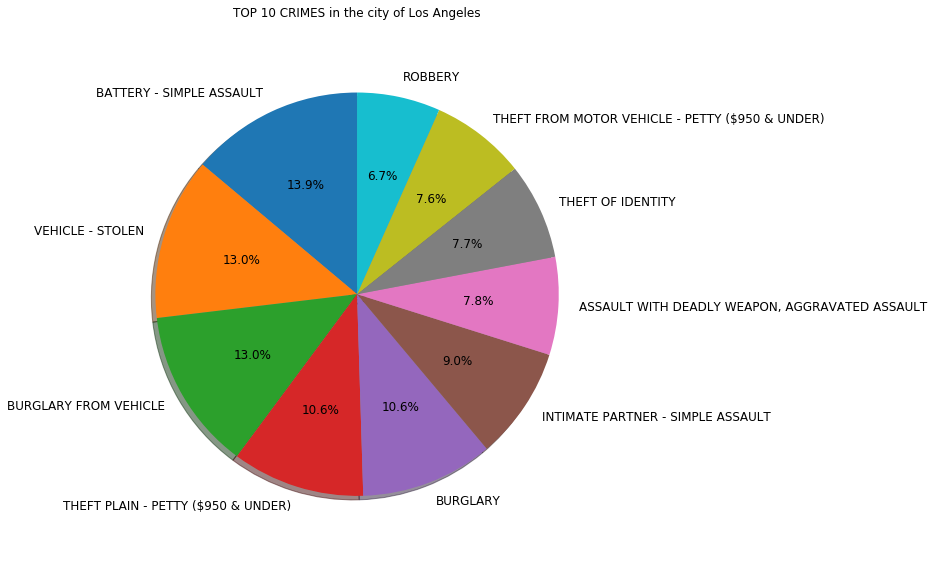

In [69]:
#plotting a pie chart
labels = crime_count.index
sizes = crime_count.values
plt.title('TOP 10 CRIMES in the city of Los Angeles')
plt.pie(sizes, labels=labels,autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 12})
fig = plt.gcf()
fig.set_size_inches(8,10) 
plt.axis('equal')
plt.show()

Plotting crime distribution in the city of Los Angeles on its map.

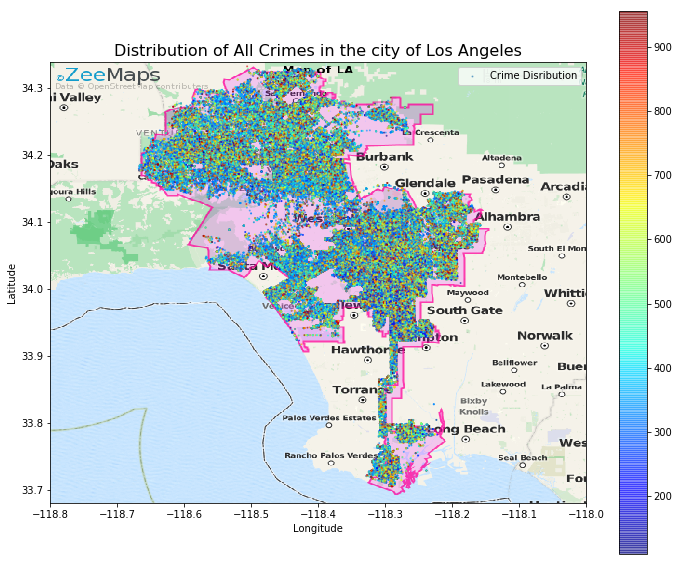

In [70]:
plt.figure(figsize=(12,10))
img=plt.imread('LosAngeles.png')
plt.imshow(img,zorder=0.1,extent=[-118.8,-118,33.68,34.34])

plt.scatter(x=df['Longitude'],y=df['Latitude'],alpha=0.5,s=1,c=df['Crime Code'],
            cmap=plt.get_cmap("jet"),zorder=1,label='Crime Disribution')
plt.colorbar()
plt.title("Distribution of All Crimes in the city of Los Angeles",size=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

In [71]:
print('Top 5 locations in Los Angeles where most crime is occuring')
df['Area Name'].value_counts().head()

Top 5 locations in Los Angeles where most crime is occuring


77th Street    28016
Southwest      26121
Central        22691
N Hollywood    22131
Pacific        21928
Name: Area Name, dtype: int64

# Data preprocessing continued

FurtherExploratory Analysis will be continued after this module of Data preprocessing.


Below we are combining crime code descriptions related to theft into a single word theft. 

The purpose of doing this is we want to train a model just on the theft related crimes and find the occurence day or shift given certain input features.

Also this will be useful to perform exploratory analysis of total number and location where theft has occured.

In [72]:
df1=df.copy(deep=True) #dataframe copied for filtering purpose. Main dataframe is kept as is. 

We need to filter all the crimes related to theft for this, so we will remove punctuations and other symbols from this text first.

In [73]:
df1['Crime Code Description'] = df1['Crime Code Description'].str.replace('$','')
df1['Crime Code Description'] = df1['Crime Code Description'].str.replace('&','')
df1['Crime Code Description'] = df1['Crime Code Description'].str.replace('(','')
df1['Crime Code Description'] = df1['Crime Code Description'].str.replace(')','')
df1['Crime Code Description'] = df1['Crime Code Description'].str.replace('-','')

Here we are replacing all the crimes related to theft by the word Theft. 

Later we will filter this dataframe using the word 'Theft' for Crime code description. This will help us in getting a dataframe related to theft only.

In [74]:
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'BIKE  STOLEN':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'BIKE  ATTEMPTED STOLEN':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'BURGLARY FROM VEHICLE, ATTEMPTED':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'BURGLARY FROM VEHICLE':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'BURGLARY, ATTEMPTED':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'BURGLARY':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'PICKPOCKET, ATTEMPT':'Theft'}, regex=True)

df1['Crime Code Description'] = df1['Crime Code Description'].replace({'PICKPOCKET':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'PURSE SNATCHING  ATTEMPT':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'PURSE SNATCHING':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'SHOPLIFTING  ATTEMPT':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'SHOPLIFTING  PETTY THEFT 950  UNDER':'Theft'}, regex=True)


df1['Crime Code Description'] = df1['Crime Code Description'].replace({'SHOPLIFTINGGRAND THEFT 950.01  OVER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT FROM MOTOR VEHICLE  PETTY 950  UNDER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT FROM MOTOR VEHICLE  ATTEMPT':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT FROM MOTOR VEHICLE  GRAND 400 AND OVER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT FROM PERSON  ATTEMPT':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT PLAIN  ATTEMPT':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT, COIN MACHINE  ATTEMPT':'Theft'}, regex=True)


df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT, COIN MACHINE  PETTY 950  UNDER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT, COIN MACHINE  GRAND 950.01  OVER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT, PERSON':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFTGRAND 950.01  OVEREXCPT,GUNS,FOWL,LIVESTK,PROD0036':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFTGRAND 950.01  OVEREXCPT,GUNS,FOWL,LIVESTK,PROD':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'TILL TAP  ATTEMPT':'Theft'}, regex=True)

df1['Crime Code Description'] = df1['Crime Code Description'].replace({'TILL TAP  PETTY 950  UNDER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'TILL TAP  GRAND THEFT 950.01  OVER':'Theft'}, regex=True)
df1['Crime Code Description'] = df1['Crime Code Description'].replace({'THEFT PLAIN  PETTY 950  UNDER':'Theft'}, regex=True)

In [75]:
len(df1['Crime Code Description'].value_counts())

118

Here we filter the above dataframe based on the word theft.

dfb-dataframe filtered from df1.

df1-has all crimes related to theft renamed as tehft

In [76]:
dfb=df1[df1['Crime Code Description'].str.contains('Theft')] #filtering dataframe containing only theft word in crime description
dfb = dfb.reset_index(drop=True)
dfb.tail()

DR Number Date Reported Date Occurred  Time Occurred  Area ID  \
150579  180719482    11/10/2018    2018-11-10            100        7   
150580  181018418    11/10/2018    2018-11-10            950       10   
150581  181119259    11/10/2018    2018-11-10            215       11   
150582  181520986    11/10/2018    2018-11-10           1015       15   
150583  181521014    11/10/2018    2018-11-10            300       15   

          Area Name  Reporting District  Crime Code Crime Code Description  \
150579     Wilshire                 721         310                  Theft   
150580  West Valley                1039         442                  Theft   
150581    Northeast                1151         310                  Theft   
150582  N Hollywood                1591         420                  Theft   
150583  N Hollywood                1583         330                  Theft   

              MO Codes    ...      dayofyear day_of_week day_id  area_id  \
150579  0344 1402 1414    ...            314    Saturday      6       20   
150580       0325 2004    ...            314    Saturday      6       19   
150581  0344 0400 2004    ...            314    Saturday      6       10   
150582             NaN    ...            314    Saturday      6        8   
150583  1302 1609 1307    ...            314    Saturday      6        8   

       dayid_sin  dayid_cos timedayid_sin timedayid_cos month_sin  month_cos  
150579 -0.781831    0.62349      0.000000           1.0 -0.866025        0.5  
150580 -0.781831    0.62349      0.866025          -0.5 -0.866025        0.5  
150581 -0.781831    0.62349      0.000000           1.0 -0.866025        0.5  
150582 -0.781831    0.62349      0.866025          -0.5 -0.866025        0.5  
150583 -0.781831    0.62349      0.000000           1.0 -0.866025        0.5  

[5 rows x 44 columns]

In [77]:
del dfb['Crime_plt']  
#this column was created in main dataframe df and has strings for all descriptions that are merged into theft.

In [78]:
dfb['Crime_plt']=dfb['Crime Code Description'] 
#now we get a column with only theft,
#this will be useful when we plot map of Los angeles with that shows where theft occured in the past

In [79]:
dfb=MultiColumnLabelEncoder(columns = ['Crime_plt']).fit_transform(dfb) #for plotting purpose

In [80]:
print('Top 5 regions where most theft is occuring.')
dfb['Area Name'].value_counts().head()

Top 5 regions where most theft is occuring.


Pacific        10114
Southwest       9145
N Hollywood     9023
Central         8720
Wilshire        8497
Name: Area Name, dtype: int64

# Further Exploratory Data Analysis 

Here we explore dataframe (df1) in which we combined all crime code descriptions related to theft into one theft

and also we will explore dataframe (dfb), which is the filtered dataframe from df1, containing only theft crimes.

Below pie chart shows top 5 crimes when,  Crime Code description related to Theft are combined, df1 is the concerned dataframe 

In [81]:
crime_count2=df1['Crime Code Description'].value_counts()
crime_count2=crime_count2[:6,]

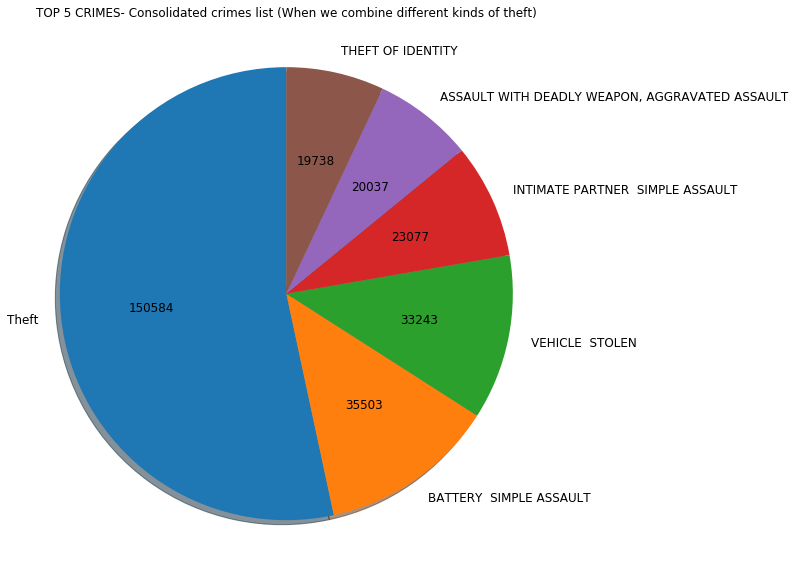

In [82]:
labels = crime_count2.index
sizes = crime_count2.values
total=sum(sizes)
plt.title('TOP 5 CRIMES- Consolidated crimes list (When we combine different kinds of theft)')
plt.pie(sizes, labels=labels,autopct=lambda p:'{:.0f}'.format(p * total / 100), shadow=True, startangle=90,textprops={'fontsize': 12})
fig = plt.gcf()
fig.set_size_inches(9,10) 
plt.axis('equal')
plt.show()

Below pie chart shows top 5 areas where theft is occuring in the city of Los Angeles.

dataframe used - dfb- ( dataframe filtered for theft crimes)

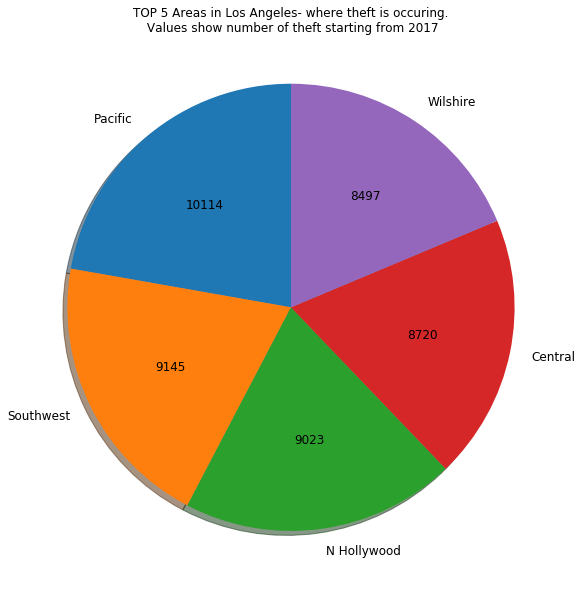

In [83]:
area_count=dfb['Area Name'].value_counts()
area_count=area_count[:5,]

labels = area_count.index
sizes = area_count.values
total=sum(sizes)
plt.title('TOP 5 Areas in Los Angeles- where theft is occuring.\n Values show number of theft starting from 2017')


plt.pie(sizes, labels=labels,autopct=lambda p:'{:.0f}'.format(p * total / 100), shadow=True, startangle=90,textprops={'fontsize': 12})


fig = plt.gcf()
fig.set_size_inches(9,10) 
plt.axis('equal')
plt.show()

SCATTER PLOT showing Distrbution of all the crimes in the city of Los Angeles.

Text(0.5,1,'Distribution of all Crimes')

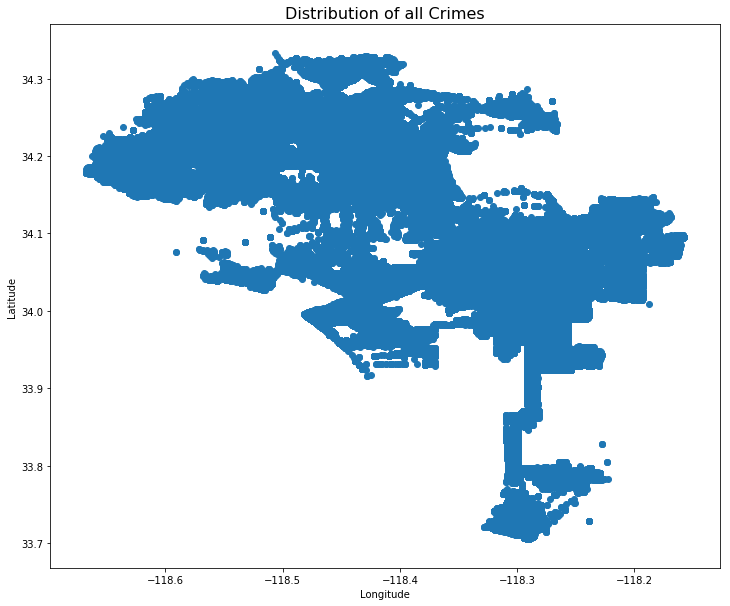

In [84]:
plt.figure(figsize=(12,10))
plt.scatter(x=df1['Longitude'],y=df1['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Distribution of all Crimes",size=16)

Below plot shows areas in the city of Los Angeles where theft has occured sincelast 2 years 

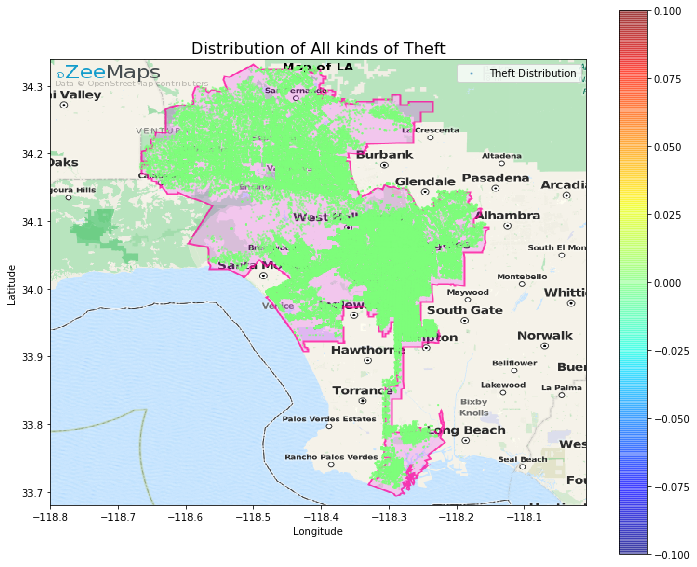

In [85]:
plt.figure(figsize=(12,10))
img=plt.imread('LosAngeles.png')
plt.imshow(img,zorder=0.1,extent=[-118.8,-118.009,33.68,34.34])

plt.scatter(x=dfb['Longitude'],y=dfb['Latitude'],alpha=0.5,s=1,c=dfb['Crime_plt'],
            cmap=plt.get_cmap("jet"),zorder=1,label='Theft Distribution')
plt.colorbar()
plt.title("Distribution of All kinds of Theft",size=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Plotting an interactive map of Los Angeles.

First we will see top 5places where theft is happening. We identified this places earlier earlier.
We will be using interactive folium map for this purpose.

In [86]:
#filtering theft dataframe (dfb) by specifying Area name as condition
locations_p = dfb[['Latitude', 'Longitude']].loc[dfb['Area Name'] == 'Pacific'].reset_index(drop=True)
locations_s = dfb[['Latitude', 'Longitude']].loc[dfb['Area Name'] == 'Southwest'].reset_index(drop=True)
locations_n = dfb[['Latitude', 'Longitude']].loc[dfb['Area Name'] == 'N Hollywood'].reset_index(drop=True)
locations_c = dfb[['Latitude', 'Longitude']].loc[dfb['Area Name'] == 'Central'].reset_index(drop=True)
locations_w = dfb[['Latitude', 'Longitude']].loc[dfb['Area Name'] == 'Wilshire'].reset_index(drop=True)

#putting the latitude and longitude values to a list
locationlist_p = locations_p.values.tolist()
locationlist_s = locations_s.values.tolist()
locationlist_n = locations_n.values.tolist()
locationlist_c = locations_c.values.tolist()
locationlist_w = locations_w.values.tolist()

In [87]:
#we will update markers for each area by latitude and longitude so that we can plot afterwards

marker_p=[]
for i in locationlist_p:
    marker_p.append(folium.CircleMarker(location=i))

marker_s=[]
for i in locationlist_s:
    marker_s.append(folium.CircleMarker(location=i))

marker_n=[]
for i in locationlist_n:
    marker_n.append(folium.CircleMarker(location=i))

marker_c=[]
for i in locationlist_c:
    marker_c.append(folium.CircleMarker(location=i))

marker_w=[]
for i in locationlist_w:
    marker_w.append(folium.CircleMarker(location=i))

In [88]:
folium_map = folium.Map(location=[33.958,-118.4437],
                        zoom_start=12,
                        tiles="CartoDB dark_matter")

marker_cluster = folium.plugins.MarkerCluster().add_to(folium_map)

for i in range(9113,10114):
    
    folium.Marker(locationlist_p[i], popup=dfb['Crime Code Description'][i]).add_to(marker_cluster)

    marker_p[i].add_to(folium_map)

print('Interactive map of thefts occuring in the city of LA in Pacific region since September 2018')
folium_map

Interactive map of thefts occuring in the city of LA in Pacific region since September 2018


In [89]:
folium_map = folium.Map(location=[33.958,-118.4437],
                        zoom_start=12,
                        tiles="CartoDB dark_matter")

marker_cluster = folium.plugins.MarkerCluster().add_to(folium_map)

for i in range(8144,9144):
    
    folium.Marker(locationlist_s[i], popup=dfb['Crime Code Description'][i]).add_to(marker_cluster)

    marker_s[i].add_to(folium_map)

print('Interactive map of thefts occuring in the city of LA in Southwest region since September 2018')
folium_map

Interactive map of thefts occuring in the city of LA in Southwest region since September 2018


Analysing distribution of only thefts throughout the LA since November 2018.

In [90]:
locations = dfb[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()

In [91]:
marker=[]
j=0
for i in locationlist:
    marker.append(folium.CircleMarker(location=i))

In [92]:
folium_map = folium.Map(location=[34.0522,-118.2437],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

marker_cluster = folium.plugins.MarkerCluster().add_to(folium_map)

for i in range(149583,150583):
    
    folium.Marker(locationlist[i], popup=dfb['day_of_week'][i]).add_to(marker_cluster)

    marker[i].add_to(folium_map)

print('This interactive map shows all the theft that occured in city of Los Angeles in since 4 November(1000 most recent events).\nIndividual values when clicked show the day of the weekday of occurence ')
folium_map

This interactive map shows all the theft that occured in city of Los Angeles in since 4 November(1000 most recent events).
Individual values when clicked show the day of the weekday of occurence 


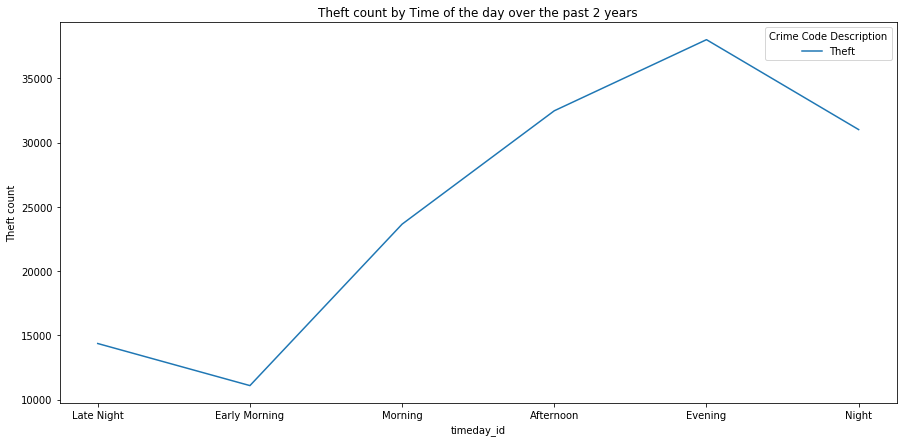

In [93]:
sorter2 = ['','Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening','Night']

fig, ax = plt.subplots(figsize=(15,7))
plt.title('Theft count by Time of the day over the past 2 years')
ax.set_xticklabels(sorter2, rotation=45, fontsize=10 )

ax.set_xlabel("Time of the day")
ax.set_ylabel("Theft count")
dfb.groupby(['timeday_id', 'Crime Code Description'])['Crime Code Description'].count().unstack().plot(ax=ax)

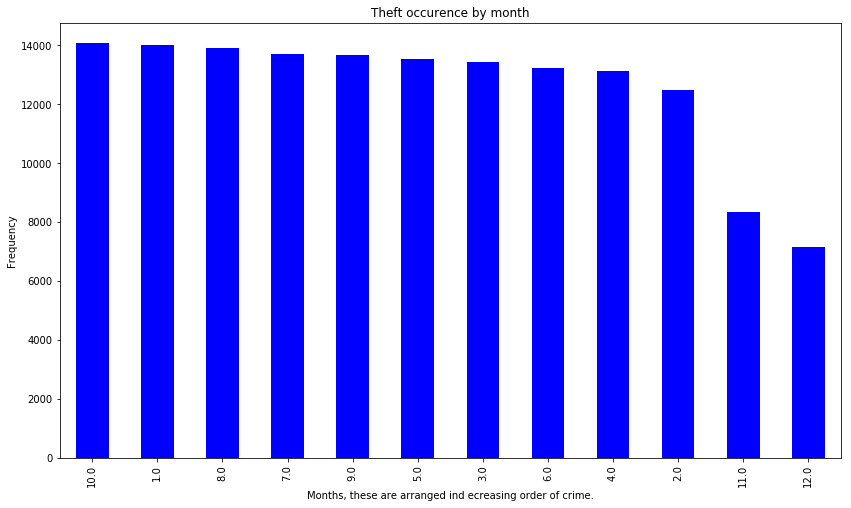

In [94]:
#sorter3 = ['','Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening','Night']

ax = dfb['month'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Theft occurence by month", color='b')
ax.set_xlabel("Months, these are arranged ind ecreasing order of crime.")
ax.set_ylabel("Frequency")
plt.show()

# Model Preparation and prediction for only theft crimes

Here we are preparing a model where we will predict shift of the day,given all the below mentioned features as input.

In [95]:
feature_cols = ['Reporting District','month_sin','month_cos','dayid_sin','dayid_cos','Latitude','Longitude','Crime Code'
               ,'Premise Code']

X = dfb[feature_cols]

target_cols=['Shift_id']

y = dfb[target_cols]

Training and splitting data. First we will use the Gradient Boosting classifier

In [96]:
sm = SMOTE()  #we want to represent all the classes equally.
X, y = sm.fit_sample(X,y.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [98]:
gbc = GradientBoostingClassifier(n_estimators=750,learning_rate=0.3)

In [99]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=750,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Model prediction

In [100]:
y_pred=gbc.predict(X_test)

In [132]:
acc=accuracy_score(y_pred, y_test)
print('Accuracy for Gradient Boosting is', '%.2f' % (acc*100),'%')

Accuracy for Gradient Boosting is 56.41 %


Using Random Forest Classifier

In [102]:
rfc=RandomForestClassifier(n_estimators=750) #same number as estimators as before.

In [103]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [126]:
y_pred_rf=gbc.predict(X_test)
acc_rf=accuracy_score(y_pred_rf, y_test)


In [133]:
print('Accuracy for Random Forest is', '%.2f' % (acc_rf*100),'%')

Accuracy for Random Forest is 56.41 %


Using XGBoostClassifier

In [105]:
xgbc=xgboost.XGBClassifier(n_estiamtors=750,learning_rate=0.3)

In [106]:
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estiamtors=750,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [134]:
y_pred_xg=xgbc.predict(X_test)
acc_xg=accuracy_score(y_pred_xg, y_test)
print('Accuracy for XGBOost is', '%.2f' % (acc_xg*100),'%')

Accuracy for XGBOost is 55.93 %


# Plotting the predicted values from gradient Boosting classifier on an interactive map.

In [108]:
lat=[]
long=[]
for i in range(len(X_test)):
    lat.append(X_test[i][5])
    long.append(X_test[i][6])   #taking latitude and longitude values in a list

In [110]:
y_predicted=y_pred.tolist()   

#taking predicted shifts value in a list

In [111]:
df_pred = pd.DataFrame({'Latitude' : lat,
 'Longitude' : long,
  'Predicted shifts': y_predicted})    #making a dataframe of above three lists

In [112]:
df_pred.head()

Latitude   Longitude  Predicted shifts
0  34.214383 -118.573838                 0
1  34.247600 -118.606400                 2
2  33.949000 -118.374400                 2
3  34.157600 -118.422500                 1
4  34.046200 -118.543100                 2

In [113]:
shift_description=[]
for i in range(len(df_pred)):
    if df_pred['Predicted shifts'][i]==0:
         shift_description.append('AM Watch')
    if df_pred['Predicted shifts'][i]==1:
         shift_description.append('Day Watch')
    if df_pred['Predicted shifts'][i]==2:
         shift_description.append('PM Watch')

In [114]:
df_pred['Shift Description']=shift_description

In [115]:
locations_pr = df_pred[['Latitude', 'Longitude']]
locationlist_pr = locations_pr.values.tolist()
marker_pr=[]
for i in locationlist_pr:
    marker_pr.append(folium.CircleMarker(location=i))

In [116]:
folium_map_pr = folium.Map(location=[34.0522,-118.2437],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")

marker_cluster = folium.plugins.MarkerCluster().add_to(folium_map_pr)

for i in range(1000):
    
    folium.Marker(locationlist[i], popup=df_pred['Shift Description'][i]).add_to(marker_cluster)

    marker[i].add_to(folium_map_pr)

print('This interactive map shows all the the predicted shifts when theft might occur for first 1000 data of test set.\n Click on individual value to find predicted shift')
folium_map_pr

This interactive map shows all the the predicted shifts when theft might occur for first 1000 data of test set.
 Click on individual value to find predicted shift


# Confusion Matrix for Gradient Boosting classifier

In [117]:
cm = confusion_matrix(y_pred,y_test)
print(cm)

[[12349  3116   964]
 [ 3631 10538  6837]
 [ 5781  8075 13869]]


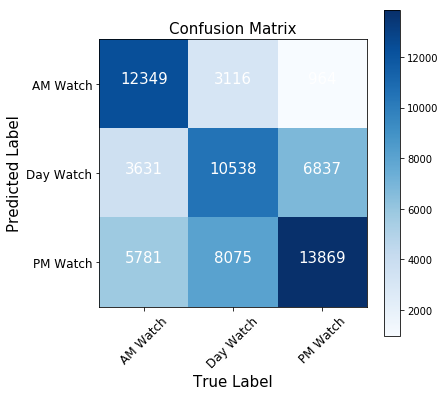

In [118]:
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['AM Watch','Day Watch','PM Watch'], rotation=45, fontsize=12)
plt.yticks(tick_marks,['AM Watch','Day Watch','PM Watch'], fontsize=12)
plt.xlabel('True Label', fontsize=15)
plt.ylabel('Predicted Label', fontsize=15)

for i in range(len(cm)):
    for j in range(len(cm[i])):
        color = 'black'   
        if cm[i][j] > 5:
            color = 'white'
        plt.text(j, i, format(cm[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)